In [143]:
import cv2
import pykitti
import numpy as np
from matplotlib import pyplot as plt

kitty_dir = 'kitti/drives'
kitty_date = '2011_09_26'
kitty_drive = '0002'

data = pykitti.raw(kitty_dir, kitty_date, kitty_drive)

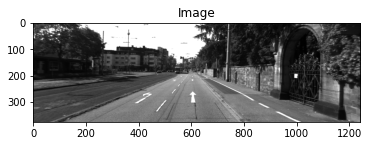

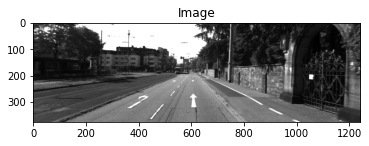

In [145]:
img1 = np.array(data.get_cam0(50))
img2 = np.array(data.get_cam0(51))
K = data.calib.K_cam0

plt.subplot(2, 1, 1)
plt.imshow(img1, cmap='gray')
plt.title('Image')
plt.show()
plt.subplot(2, 1, 2)
plt.imshow(img2, cmap='gray')
plt.title('Image')
plt.show()

## Detect Features

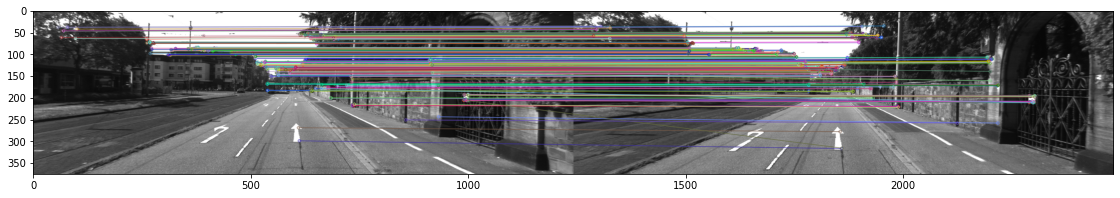

In [146]:
# From: https://stackoverflow.com/a/33670318
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)
img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=2)
plt.figure(figsize=(30, 3))
plt.imshow(img3)
plt.show()

In [147]:
# From book
imgpts1 = []
imgpts2 = []
for match in matches:
	imgpts1.append(kp1[match.queryIdx].pt)
	imgpts2.append(kp2[match.trainIdx].pt)

points1 = np.array(imgpts1)
points2 = np.array(imgpts2)

F, status_mask = cv2.findFundamentalMat(points1, points2, cv2.FM_RANSAC, 0.1, 0.99, 10000000)
E = K.T @ F @ K
print("E:", E)

print(f"Keeping {np.sum(status_mask)}/{status_mask.size} points that match the fundamental matrix")
points1 = points1[status_mask[:, 0]]
points2 = points2[status_mask[:, 0]]



E: [[-3.81770942e-03 -2.76868273e+02 -2.57759220e+01]
 [ 2.87332873e+02 -2.61995216e+00 -1.90207309e+03]
 [ 2.67767887e+01  1.90302478e+03  1.08742304e-01]]
Keeping 120/348 points that match the fundamental matrix


In [148]:
# From book
def P_from_E(E):
	# ???: It seems like all the data here is in w, which we
	w, u, vt = cv2.SVDecomp(E)

	W = np.array([
		[0, -1 , 0],
		[1, 0, 0],
		[0, 0, 1]
	])

	R = u @ W @ vt
	t = u[:, 2]

	assert np.abs(np.linalg.det(R)) - 1.0 <= 1e-07, "det(R) != ±1.0, this isn't a rotation matrix!"

	P = np.hstack((R, t[:,np.newaxis]))
	return P

P1 = P_from_E(E)
# P0 is assumed to be fixed
P = np.array([
	[1, 0, 0, 0],
	[0, 1, 0, 0],
	[0, 0, 1, 0]
])

P, P1

(array([[1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0]]),
 array([[ 0.9566098 , -0.02692886,  0.29012502,  0.98949542],
        [-0.02712061, -0.99962652, -0.00336047, -0.01340091],
        [ 0.29010716, -0.00465371, -0.95698285,  0.14394178]]))

## Triangulation

In [149]:
# From book
def triangulate(
	# NOTE: u and u1 need to be normalized (multiplied by K, or P and P1 do)
	u: np.array, # point in image 1: (x, y, 1)
	P: np.array, # camera 1 matrix
	u1: np.array, # point in image 2: (x, y, 1)
	P1: np.array, # camera 2 matrix
):
	# XXX: I don't quite understand this
	A = np.array([
		[ u[0]*P[2,0]-P[0,0],    u[0]*P[2,1]-P[0,1],    u[0]*P[2,2]-P[0,2]],
		[ u[1]*P[2,0]-P[1,0],    u[1]*P[2,1]-P[1,1],    u[1]*P[2,2]-P[1,2]],
		[u1[0]*P1[2,0]-P1[0,0], u1[0]*P1[2,1]-P1[0,1], u1[0]*P1[2,2]-P1[0,2]],
		[u1[1]*P1[2,0]-P1[1,0], u1[1]*P1[2,1]-P1[1,1], u1[1]*P1[2,2]-P1[1,2]]
	])

	B = np.array([
		-(u[0]*P[2, 3]-P[0, 3]),
		-(u[1]*P[2, 3]-P[1, 3]),
		-(u1[0]*P1[2, 3]-P1[0, 3]),
		-(u1[1]*P1[2, 3]-P1[1, 3])
	])

	_, X = cv2.solve(A, B, flags=cv2.DECOMP_SVD)
	return np.array([*X[:, 0], 1.0])


In [150]:
# From book
def triangulate_points(
	pt_set1: np.array,
	pt_set2: np.array,
	K: np.array,
	P: np.array,
	P1: np.array,
):
	Kinv = np.linalg.inv(K)
	reproj_error = []
	point_cloud = []
	
	for kp, kp1 in zip(pt_set1, pt_set2):
		# Convert to normalized, homogeneous coordinates
		u = Kinv @ np.array([*kp, 1.0])
		u1 = Kinv @ np.array([*kp1, 1.0])

		# Triangulate
		X = triangulate(u, P, u1, P1)

		# Calculate reprojection error
		xPt_img = K @ P1 @ X
		xPt_img_normalized = xPt_img[0:1] / xPt_img[2]
		reproj_error.append(np.linalg.norm(xPt_img_normalized))
		point_cloud.append(X)
	
	# Return mean reprojection error
	return np.mean(reproj_error)


triangulate_points(points1, points2, K, P, P1)


365.10049700533204